In [1]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot, jointcnmodels
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

def map_ids(sample_inds, ids):
    return [list(ids[ind_list]) for ind_list in sample_inds]

In [2]:
cn_data_fp = "/Users/massoudmaher/data/sc1935to37_spike_in_chrX.csv"
cn_data = pd.read_csv(cn_data_fp).iloc[:,1:]

In [3]:
cn_data.head(10)
cn_data = cn_data[cn_data["end"] <= 5000000]

In [4]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 8
alpha = 3
prob_cn_change = 0.9
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [5]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy", debug=True)
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

li 0
li 1
li 2
li 3
li 4
li 5
li 6
li 7
li 8
li 9
li 10
li 11
li 12
li 13
li 14
li 15
li 16
li 17
li 18
li 19
li 20
li 21
li 22
li 23
li 24
li 25
li 26
li 27
li 28
li 29
li 30
li 31
li 32
li 33
li 34
li 35
li 36
li 37
li 38
li 39
li 40
li 41
li 42
li 43
li 44
li 45
li 46
li 47
li 48
li 49
li 50
li 51
li 52
li 53
li 54
li 55
li 56
li 57
li 58
li 59
li 60
li 61
li 62
li 63
li 64
li 65
li 66
li 67
li 68
li 69
li 70
li 71
li 72
li 73
li 74
li 75
li 76
li 77
li 78
li 79
li 80
li 81
li 82
li 83
li 84
li 85
li 86
li 87
li 88
li 89
li 90
li 91
li 92
li 93
li 94
li 95
li 96
li 97
li 98
8.52829098701477s for BHC on 100 cells


homogeneity: 0.8344951133932672, completeness: 0.22665684474871595, v-measure: 0.3564881125811996


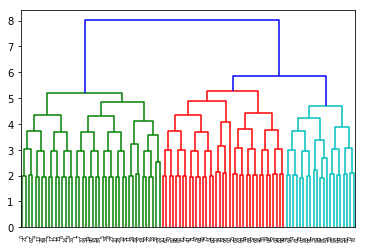

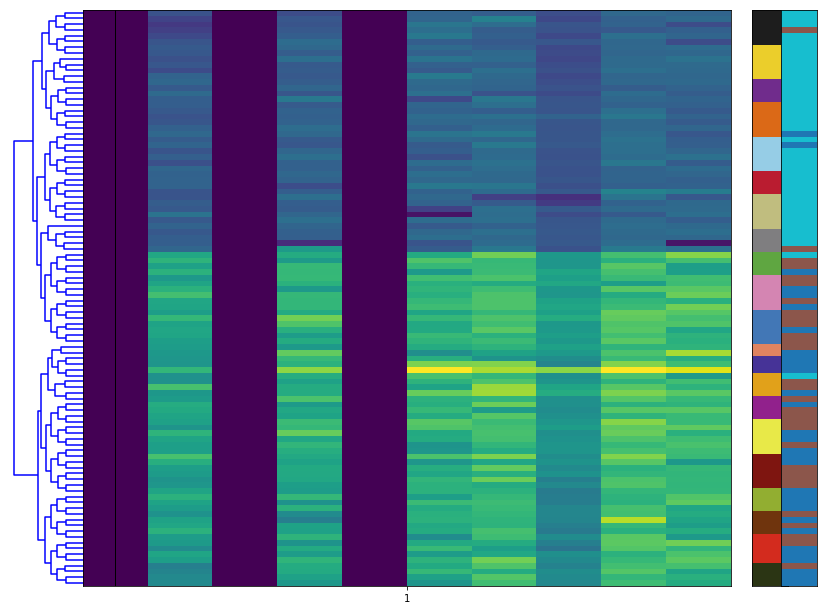

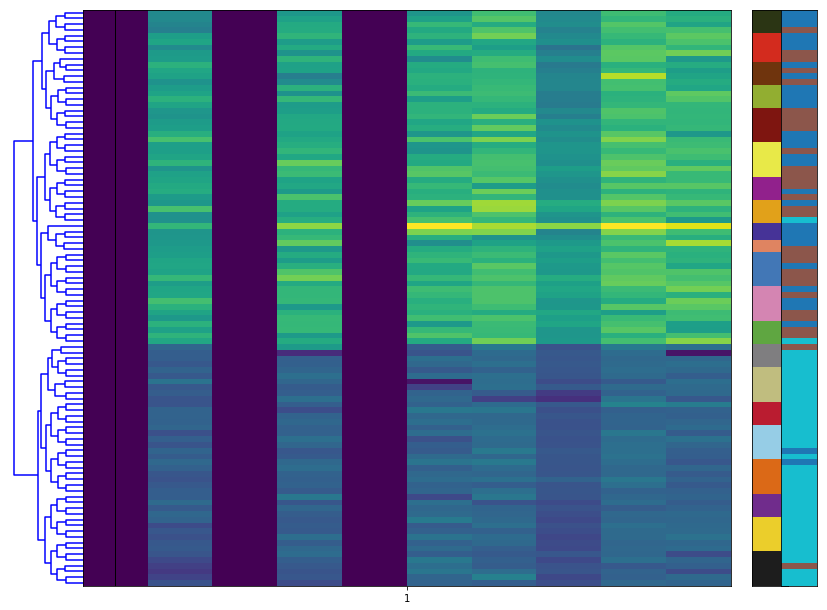

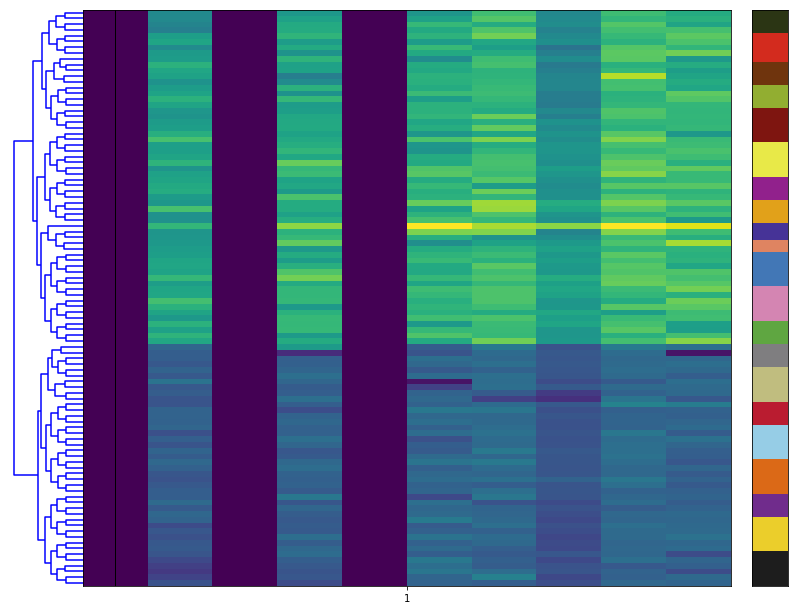

In [7]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

dend = sch.dendrogram(lbhc_plot_data)

bhc_clusters = sch.fcluster(bhc_plot_data, 8, criterion="distance")
assert len(set(bhc_clusters)) > 1
cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, cn_data)
cn_data["origin_id_int"] = cn_data["origin_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=False,
    cell_id_order=bhc_cell_ids)

fig = plt.figure(figsize=(10, 8))
bimatrix_data1, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=True,
    cell_id_order=bhc_cell_ids)

fig = plt.figure(figsize=(10, 8))
bimatrix_data1, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name=None, raw=True, flip=True,
    cell_id_order=bhc_cell_ids)

clabels = get_mixture_labels(cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [7]:
display(bimatrix_data) 

cell_id           SA1090-A96213A-R20-C22 SA1090-A96213A-R31-C53  \
bhc_cluster_id                        1                      1    
origin_id_int                          2                      2   
cell_order                            0                      1    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.756607               0.598613   
          1000001               0.000000               0.000000   
          1500001               0.690024               0.805603   
          2000001               0.000000               0.000000   
          2500001               0.944582               0.974693   
          3000001               0.895508               1.315209   
          3500001               0.717829               0.652067   
          4000001               1.006939               0.925154   
          4500001               0.962712               1.016973   

cell_id           SA1090-A96213A-R20-C64 SA921-A90554A-R12-C26  \
bhc_cluster_id                        2                     2    
origin_id_int                          2                     1   
cell_order                            2                     3    
chr_index start                                                  
22        1                     0.000000              0.000000   
          500001                0.491571              0.569956   
          1000001               0.000000              0.000000   
          1500001               0.773983              0.829233   
          2000001               0.000000              0.000000   
          2500001               1.166773              1.080902   
          3000001               1.060962              0.878690   
          3500001               0.789420              0.763747   
          4000001               0.948605              0.829823   
          4500001               0.689592              0.916847   

cell_id           SA1090-A96213A-R24-C15 SA1090-A96213A-R28-C29  \
bhc_cluster_id                        3                      3    
origin_id_int                          2                      2   
cell_order                            4                      5    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.653688               0.789074   
          1000001               0.000000               0.000000   
          1500001               0.887902               1.056369   
          2000001               0.000000               0.000000   
          2500001               1.193840               0.886349   
          3000001               0.919853               0.848389   
          3500001               0.654493               0.805889   
          4000001               1.092607               0.994634   
          4500001               0.967279               0.697065   

cell_id           SA1090-A96213A-R33-C22 SA1090-A96213A-R35-C41  \
bhc_cluster_id                        4                      4    
origin_id_int                          2                      2   
cell_order                            6                      7    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.839014               0.822635   
          1000001               0.000000               0.000000   
          1500001               1.002292               0.876072   
          2000001               0.000000               0.000000   
          2500001               1.035848               0.929062   
          3000001               0.905893               1.024124   
          3500001               0.661698               0.676095   
          4000001               1.004269               0.988767   
          4500001               1.041351               0.99

In [8]:
matrix_data["copy"]

cell_id      SA1090-A96213A-R20-C22  SA1090-A96213A-R20-C25  \
chr start                                                     
X   1                           NaN                     NaN   
    500001                 0.756607                0.888281   
    1000001                     NaN                     NaN   
    1500001                0.690024                0.850627   
    2000001                     NaN                     NaN   
    2500001                0.944582                0.968188   
    3000001                0.895508                1.086817   
    3500001                0.717829                0.792749   
    4000001                1.006939                0.940817   
    4500001                0.962712                0.922727   

cell_id      SA1090-A96213A-R20-C64  SA1090-A96213A-R22-C39  \
chr start                                                     
X   1                           NaN                     NaN   
    500001                 0.491571                0.744416   
    1000001                     NaN                     NaN   
    1500001                0.773983                1.083178   
    2000001                     NaN                     NaN   
    2500001                1.166773                1.139419   
    3000001                1.060962                1.037611   
    3500001                0.789420                0.632915   
    4000001                0.948605                1.035710   
    4500001                0.689592                1.121419   

cell_id      SA1090-A96213A-R24-C15  SA1090-A96213A-R24-C22  \
chr start                                                     
X   1                           NaN                     NaN   
    500001                 0.653688                0.779900   
    1000001                     NaN                     NaN   
    1500001                0.887902                0.986975   
    2000001                     NaN                     NaN   
    2500001                1.193840                0.890039   
    3000001                0.919853                1.033820   
    3500001                0.654493                0.758594   
    4000001                1.092607                1.091658   
    4500001                0.967279                0.983685   

cell_id      SA1090-A96213A-R24-C42  SA1090-A96213A-R24-C46  \
chr start                                                     
X   1                           NaN                     NaN   
    500001                 0.996611                0.838369   
    1000001                     NaN                     NaN   
    1500001                0.873914                0.935381   
    2000001                     NaN                     NaN   
    2500001                1.032571                0.940192   
    3000001                0.985901                0.888530   
    3500001                0.716802                0.792227   
    4000001                1.005350                1.089490   
    4500001                1.017667                0.848012   

cell_id      SA1090-A96213A-R24-C64  SA1090-A96213A-R26-C62  ...  \
chr start                                                    ...   
X   1                           NaN                     NaN  ...   
    500001                 0.727040                1.033322  ...   
    1000001                     NaN                     NaN  ...   
    1500001                0.923114                0.800200  ...   
    2000001                     NaN                     NaN  ...   
    2500001                1.052083                1.094723  ...   
    3000001                1.107526                0.761568  ...   
    3500001                0.782029                0.685061  ...   
    4000001                1.182686                1.053593  ...   
    4500001                0.862336                0.885487  ...   

cell_id      SA922-A90554B-R31-C40  SA922-A90554B-R31-C42  \
chr start                                                   
X   1                          Na

In [10]:
new_bhc_linkage = bhc_linkage.copy()
new_bhc_linkage["sample_ids"] = map_ids(new_bhc_linkage["sample_inds"], bhc_cell_ids)
new_bhc_linkage["l_sample_ids"] = map_ids(new_bhc_linkage["l_sample_inds"], bhc_cell_ids)
new_bhc_linkage["r_sample_ids"] = map_ids(new_bhc_linkage["r_sample_inds"], bhc_cell_ids)
list(new_bhc_linkage["sample_ids"])

[['SA921-A90554A-R05-C18', 'SA922-A90554B-R28-C66'],
 ['SA922-A90554B-R25-C43', 'SA922-A90554B-R32-C12'],
 ['SA1090-A96213A-R33-C31', 'SA1090-A96213A-R34-C41'],
 ['SA1090-A96213A-R31-C37', 'SA1090-A96213A-R34-C38'],
 ['SA1090-A96213A-R31-C42', 'SA922-A90554B-R29-C42'],
 ['SA1090-A96213A-R28-C33', 'SA922-A90554B-R31-C40'],
 ['SA1090-A96213A-R20-C25', 'SA1090-A96213A-R24-C46'],
 ['SA1090-A96213A-R33-C57', 'SA1090-A96213A-R35-C47'],
 ['SA1090-A96213A-R24-C22', 'SA1090-A96213A-R34-C44'],
 ['SA1090-A96213A-R24-C64', 'SA1090-A96213A-R32-C38'],
 ['SA1090-A96213A-R31-C43', 'SA1090-A96213A-R33-C32'],
 ['SA1090-A96213A-R32-C14', 'SA1090-A96213A-R34-C37'],
 ['SA921-A90554A-R03-C14', 'SA922-A90554B-R24-C24'],
 ['SA1090-A96213A-R26-C62', 'SA1090-A96213A-R35-C32'],
 ['SA1090-A96213A-R24-C42', 'SA1090-A96213A-R28-C69'],
 ['SA1090-A96213A-R28-C18', 'SA1090-A96213A-R28-C38'],
 ['SA1090-A96213A-R22-C39', 'SA1090-A96213A-R29-C56'],
 ['SA921-A90554A-R03-C28', 'SA921-A90554A-R15-C24'],
 ['SA1090-A96213A-R2

odd_cell is "SA921-A90554A-R15-C52", repeat process on subset of cells

In [21]:
keep_cells = bimatrix_data1.iloc[:,0:11].columns.get_level_values(0)
scn_data = cn_data[cn_data["cell_id"].isin(keep_cells)].reset_index(drop=True)
print(keep_cells)

Index(['SA922-A90554B-R27-C44', 'SA922-A90554B-R25-C17',
       'SA922-A90554B-R29-C22', 'SA921-A90554A-R08-C44',
       'SA922-A90554B-R35-C58', 'SA922-A90554B-R28-C19',
       'SA922-A90554B-R30-C22', 'SA921-A90554A-R07-C25',
       'SA921-A90554A-R09-C51', 'SA922-A90554B-R28-C66',
       'SA921-A90554A-R05-C18'],
      dtype='object', name='cell_id')


idx: [ 5  4  8  2 10  6  9  1  3  7  0]
ordering: [10  7  3  8  1  0  5  9  2  6  4]


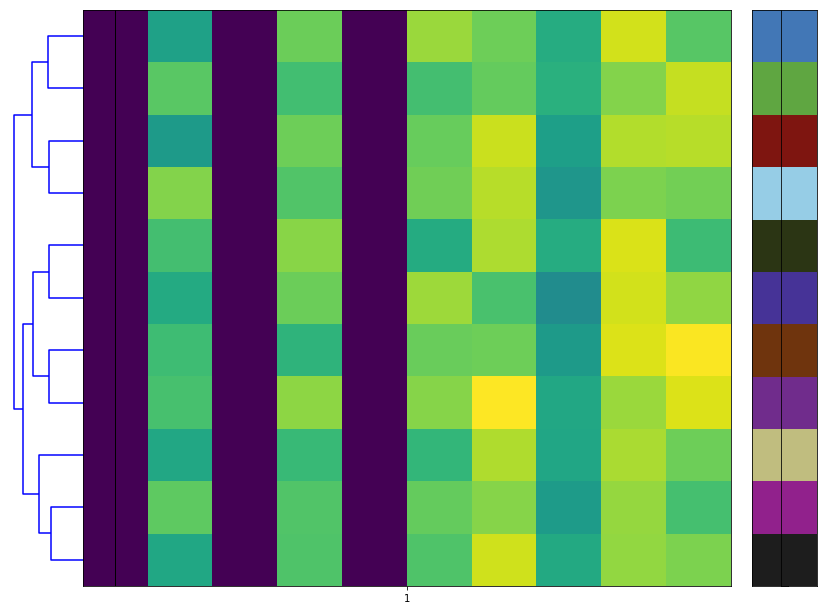

In [22]:
#scn_data = pd.read_csv("/Users/massoudmaher/data/scn_data.csv")

slinkage, sroot, scell_ids, smatrix_data, smeasurement, svariances = (
    cncluster.bayesian_cluster(scn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy", debug=True)
)

slinkage, splot_data = simulation.get_plot_data(slinkage)
lsplot_data = splot_data.copy()
lsplot_data[:,2] = np.log(splot_data[:,2]) # Log because the highest link is way higher

scn_data["origin_id_int"] = scn_data["cell_id"].factorize()[0]
scn_data["bhc_cluster_id"] = scn_data["cell_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, scn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lsplot_data, origin_field_name="origin_id_int", raw=True, 
    flip=True)


#nlinkage = sch.linkage(np.nan_to_num(smeasurement, 0))

In [23]:
display(slinkage)
nlinkage = slinkage.copy()
nlinkage["sample_ids"] = map_ids(nlinkage["sample_inds"], scell_ids)
nlinkage["l_sample_ids"] = map_ids(nlinkage["l_sample_inds"], scell_ids)
nlinkage["r_sample_ids"] = map_ids(nlinkage["r_sample_inds"], scell_ids)
display(nlinkage)

,i,j,r_merge,naive_dist,log_like,i_count,j_count,pi,d,result_ind,...,d_right,ll_left,ll_right,pi_left,pi_right,tree_ll,tree_ll_left,tree_ll_right,merge_count,dist
0,0,7,-6.799363,NaN,7.02921,1,1,-1.38629,2.48491,11,...,1.09861,5.86474,6.86411,0,0,12.4423,5.86474,6.86411,2,6.799363
1,6,10,-7.623357,NaN,2.4989,1,1,-1.38629,2.48491,12,...,1.09861,3.98915,5.03401,0,0,8.73596,3.98915,5.03401,2,7.623357
2,1,9,-7.790166,NaN,2.80853,1,1,-1.38629,2.48491,13,...,1.09861,4.14955,5.35013,0,0,9.21241,4.14955,5.35013,2,7.790166
3,2,8,-7.864451,NaN,3.77586,1,1,-1.38629,2.48491,14,...,1.09861,5.45473,5.08659,0,0,10.254,5.45473,5.08659,2,7.864451
4,4,5,-8.280793,NaN,1.14517,1,1,-1.38629,2.48491,15,...,1.09861,4.59848,3.72861,0,0,8.03967,4.59848,3.72861,2,8.280793
5,11,3,-14.377092,NaN,3.77172,2,1,-1.94591,3.73767,16,...,1.09861,7.02921,3.91477,-1.38629,0,16.2029,12.4423,3.91477,3,14.377092
6,13,12,-20.781093,NaN,-0.753284,2,2,-2.19722,5.0876,17,...,2.48491,2.80853,2.4989,-1.38629,-1.38629,17.8306,9.21241,8.73596,4,20.781093
7,14,15,-21.809201,NaN,-1.43607,2,2,-2.19722,5.0876,18,...,2.48491,3.77586,1.14517,-1.38629,-1.38629,18.1759,10.254,8.03967,4,21.809201
8,16,17,-37.740709,NaN,-2.55982,3,4,-1.42311,9.10097,19,...,5.0876,3.77172,-0.753284,-1.94591,-2.19722,33.7578,16.2029,17.8306,7,37.740709
9,19,18,-64.307533,NaN,-14.3883,7,4,-0.125216,16.3282,20,...,5.0876,-2.55982,-1.43607,-1.42311,-2.19722,49.794,33.7578,18.1759,11,64.307533


,i,j,r_merge,naive_dist,log_like,i_count,j_count,pi,d,result_ind,...,pi_left,pi_right,tree_ll,tree_ll_left,tree_ll_right,merge_count,dist,sample_ids,l_sample_ids,r_sample_ids
0,0,7,-6.799363,NaN,7.02921,1,1,-1.38629,2.48491,11,...,0,0,12.4423,5.86474,6.86411,2,6.799363,"[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66]",[SA921-A90554A-R05-C18],[SA922-A90554B-R28-C66]
1,6,10,-7.623357,NaN,2.4989,1,1,-1.38629,2.48491,12,...,0,0,8.73596,3.98915,5.03401,2,7.623357,"[SA922-A90554B-R28-C19, SA922-A90554B-R35-C58]",[SA922-A90554B-R28-C19],[SA922-A90554B-R35-C58]
2,1,9,-7.790166,NaN,2.80853,1,1,-1.38629,2.48491,13,...,0,0,9.21241,4.14955,5.35013,2,7.790166,"[SA921-A90554A-R07-C25, SA922-A90554B-R30-C22]",[SA921-A90554A-R07-C25],[SA922-A90554B-R30-C22]
3,2,8,-7.864451,NaN,3.77586,1,1,-1.38629,2.48491,14,...,0,0,10.254,5.45473,5.08659,2,7.864451,"[SA921-A90554A-R08-C44, SA922-A90554B-R29-C22]",[SA921-A90554A-R08-C44],[SA922-A90554B-R29-C22]
4,4,5,-8.280793,NaN,1.14517,1,1,-1.38629,2.48491,15,...,0,0,8.03967,4.59848,3.72861,2,8.280793,"[SA922-A90554B-R25-C17, SA922-A90554B-R27-C44]",[SA922-A90554B-R25-C17],[SA922-A90554B-R27-C44]
5,11,3,-14.377092,NaN,3.77172,2,1,-1.94591,3.73767,16,...,-1.38629,0,16.2029,12.4423,3.91477,3,14.377092,"[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66,...","[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66]",[SA921-A90554A-R09-C51]
6,13,12,-20.781093,NaN,-0.753284,2,2,-2.19722,5.0876,17,...,-1.38629,-1.38629,17.8306,9.21241,8.73596,4,20.781093,"[SA921-A90554A-R07-C25, SA922-A90554B-R30-C22,...","[SA921-A90554A-R07-C25, SA922-A90554B-R30-C22]","[SA922-A90554B-R28-C19, SA922-A90554B-R35-C58]"
7,14,15,-21.809201,NaN,-1.43607,2,2,-2.19722,5.0876,18,...,-1.38629,-1.38629,18.1759,10.254,8.03967,4,21.809201,"[SA921-A90554A-R08-C44, SA922-A90554B-R29-C22,...","[SA921-A90554A-R08-C44, SA922-A90554B-R29-C22]","[SA922-A90554B-R25-C17, SA922-A90554B-R27-C44]"
8,16,17,-37.740709,NaN,-2.55982,3,4,-1.42311,9.10097,19,...,-1.94591,-2.19722,33.7578,16.2029,17.8306,7,37.740709,"[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66,...","[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66,...","[SA921-A90554A-R07-C25, SA922-A90554B-R30-C22,..."
9,19,18,-64.307533,NaN,-14.3883,7,4,-0.125216,16.3282,20,...,-1.42311,-2.19722,49.794,33.7578,18.1759,11,64.307533,"[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66,...","[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66,...","[SA921-A90554A-R08-C44, SA922-A90554B-R29-C22,..."


In [26]:
nbhc_linkage = bhc_linkage.copy()
nbhc_linkage["sample_ids"] = map_ids(nbhc_linkage["sample_inds"], bhc_cell_ids)
nbhc_linkage["l_sample_ids"] = map_ids(nbhc_linkage["l_sample_inds"], bhc_cell_ids)
nbhc_linkage["r_sample_ids"] = map_ids(nbhc_linkage["r_sample_inds"], bhc_cell_ids)
display(nbhc_linkage)

,i,j,r_merge,naive_dist,log_like,i_count,j_count,pi,d,result_ind,...,pi_left,pi_right,tree_ll,tree_ll_left,tree_ll_right,merge_count,dist,sample_ids,l_sample_ids,r_sample_ids
0,49,81,-6.799363,NaN,7.02921,1,1,-1.38629,2.48491,100,...,0,0,12.4423,5.86474,6.86411,2,6.799363,"[SA921-A90554A-R05-C18, SA922-A90554B-R28-C66]",[SA921-A90554A-R05-C18],[SA922-A90554B-R28-C66]
1,73,92,-6.864191,NaN,7.31837,1,1,-1.38629,2.48491,101,...,0,0,12.7963,6.58969,6.49322,2,6.864191,"[SA922-A90554B-R25-C43, SA922-A90554B-R32-C12]",[SA922-A90554B-R25-C43],[SA922-A90554B-R32-C12]
2,27,33,-6.891532,NaN,17.7275,1,1,-1.38629,2.48491,102,...,0,0,23.2328,11.3098,12.2097,2,6.891532,"[SA1090-A96213A-R33-C31, SA1090-A96213A-R34-C41]",[SA1090-A96213A-R33-C31],[SA1090-A96213A-R34-C41]
3,18,32,-6.892806,NaN,16.7887,1,1,-1.38629,2.48491,103,...,0,0,22.2952,10.7283,11.8536,2,6.892806,"[SA1090-A96213A-R31-C37, SA1090-A96213A-R34-C38]",[SA1090-A96213A-R31-C37],[SA1090-A96213A-R34-C38]
4,19,84,-6.894923,NaN,14.0854,1,1,-1.38629,2.48491,104,...,0,0,19.5941,10.4735,9.40725,2,6.894923,"[SA1090-A96213A-R31-C42, SA922-A90554B-R29-C42]",[SA1090-A96213A-R31-C42],[SA922-A90554B-R29-C42]
5,14,90,-6.899009,NaN,15.8202,1,1,-1.38629,2.48491,105,...,0,0,21.333,12.1862,9.4334,2,6.899009,"[SA1090-A96213A-R28-C33, SA922-A90554B-R31-C40]",[SA1090-A96213A-R28-C33],[SA922-A90554B-R31-C40]
6,1,7,-6.901266,NaN,13.9791,1,1,-1.38629,2.48491,106,...,0,0,19.4941,10.4758,9.30499,2,6.901266,"[SA1090-A96213A-R20-C25, SA1090-A96213A-R24-C46]",[SA1090-A96213A-R20-C25],[SA1090-A96213A-R24-C46]
7,30,39,-6.906084,NaN,14.3297,1,1,-1.38629,2.48491,107,...,0,0,19.8495,10.1081,10.0281,2,6.906084,"[SA1090-A96213A-R33-C57, SA1090-A96213A-R35-C47]",[SA1090-A96213A-R33-C57],[SA1090-A96213A-R35-C47]
8,5,34,-6.915888,NaN,13.0879,1,1,-1.38629,2.48491,108,...,0,0,18.6175,9.81686,9.08736,2,6.915888,"[SA1090-A96213A-R24-C22, SA1090-A96213A-R34-C44]",[SA1090-A96213A-R24-C22],[SA1090-A96213A-R34-C44]
9,8,23,-6.926913,NaN,14.0747,1,1,-1.38629,2.48491,109,...,0,0,19.6153,8.40589,11.4961,2,6.926913,"[SA1090-A96213A-R24-C64, SA1090-A96213A-R32-C38]",[SA1090-A96213A-R24-C64],[SA1090-A96213A-R32-C38]


In [27]:
nbhc_linkage.to_csv("/Users/massoudmaher/Desktop/nbhc_linkage.csv")

In [15]:
list(nlinkage["sample_ids"])

[['SA1090-A96213A-R28-C18', 'SA1090-A96213A-R29-C56'],
 ['SA1090-A96213A-R22-C39', 'SA1090-A96213A-R28-C29'],
 ['SA1090-A96213A-R24-C15', 'SA1090-A96213A-R33-C22'],
 ['SA1090-A96213A-R20-C22', 'SA1090-A96213A-R35-C41'],
 ['SA1090-A96213A-R20-C64', 'SA921-A90554A-R12-C26'],
 ['SA1090-A96213A-R28-C18',
  'SA1090-A96213A-R29-C56',
  'SA1090-A96213A-R31-C53'],
 ['SA1090-A96213A-R22-C39',
  'SA1090-A96213A-R28-C29',
  'SA1090-A96213A-R24-C15',
  'SA1090-A96213A-R33-C22'],
 ['SA1090-A96213A-R20-C22',
  'SA1090-A96213A-R35-C41',
  'SA1090-A96213A-R20-C64',
  'SA921-A90554A-R12-C26'],
 ['SA1090-A96213A-R22-C39',
  'SA1090-A96213A-R28-C29',
  'SA1090-A96213A-R24-C15',
  'SA1090-A96213A-R33-C22',
  'SA1090-A96213A-R28-C18',
  'SA1090-A96213A-R29-C56',
  'SA1090-A96213A-R31-C53'],
 ['SA1090-A96213A-R20-C22',
  'SA1090-A96213A-R35-C41',
  'SA1090-A96213A-R20-C64',
  'SA921-A90554A-R12-C26',
  'SA1090-A96213A-R22-C39',
  'SA1090-A96213A-R28-C29',
  'SA1090-A96213A-R24-C15',
  'SA1090-A96213A-R33-C2

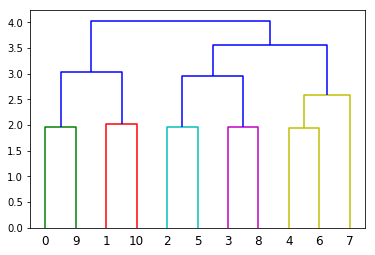

In [16]:
dend = sch.dendrogram(lsplot_data)

In [17]:
dend["leaves"]

[0, 9, 1, 10, 2, 5, 3, 8, 4, 6, 7]

In [18]:
dend

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [85.0, 85.0, 95.0, 95.0],
  [90.0, 90.0, 105.0, 105.0],
  [60.0, 60.0, 97.5, 97.5],
  [20.0, 20.0, 78.75, 78.75]],
 'dcoord': [[0.0, 1.9661889909229362, 1.9661889909229362, 0.0],
  [0.0, 2.0291524122975786, 2.0291524122975786, 0.0],
  [1.9661889909229362,
   3.029563105668958,
   3.029563105668958,
   2.0291524122975786],
  [0.0, 1.9522343984689492, 1.9522343984689492, 0.0],
  [0.0, 1.9589376025513698, 1.9589376025513698, 0.0],
  [1.9522343984689492,
   2.9566288692471874,
   2.9566288692471874,
   1.9589376025513698],
  [0.0, 1.9475789877896934, 1.9475789877896934, 0.0],
  [1.9475789877896934, 2.59289791705125, 2.59289791705125, 0.0],
  [2.9566288692471874,
   3.5663985386732833,
   3.5663985386732833,
   2.59289791705125],
  [3.029563105668958,
   4.029369583019254,
   4.029369583019254,
   3.5663985386732833

In [19]:
lbhc_plot_data

array([[ 49.        ,  81.        ,   1.91682891,   2.        ],
       [ 73.        ,  92.        ,   1.92631812,   2.        ],
       [ 27.        ,  33.        ,   1.93029334,   2.        ],
       [ 18.        ,  32.        ,   1.93047831,   2.        ],
       [ 19.        ,  84.        ,   1.93078527,   2.        ],
       [ 14.        ,  90.        ,   1.93137775,   2.        ],
       [  1.        ,   7.        ,   1.93170485,   2.        ],
       [ 30.        ,  39.        ,   1.93240272,   2.        ],
       [  5.        ,  34.        ,   1.93382133,   2.        ],
       [  8.        ,  23.        ,   1.93541432,   2.        ],
       [ 20.        ,  28.        ,   1.93680248,   2.        ],
       [ 22.        ,  31.        ,   1.9400217 ,   2.        ],
       [ 40.        ,  71.        ,   1.94139333,   2.        ],
       [  9.        ,  36.        ,   1.94228582,   2.        ],
       [  6.        ,  16.        ,   1.94362902,   2.        ],
       [ 12.        ,  15